Gemini

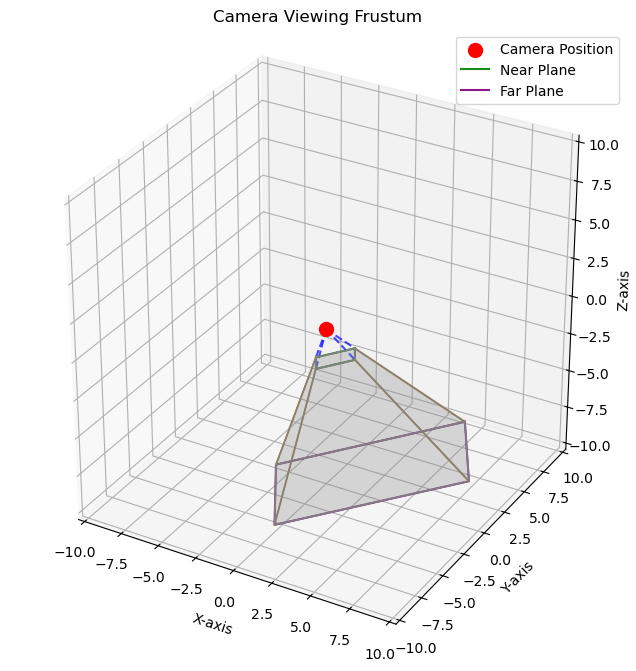

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Configuration for the Camera and Plot ---
# Camera parameters
camera_position = np.array([0, 0, 0]) # Camera position (x, y, z)
# Camera orientation in Euler angles (yaw, pitch, roll) in degrees
# Yaw: rotation around Z-axis (heading)
# Pitch: rotation around Y-axis (tilt up/down)
# Roll: rotation around X-axis (barrel roll)
# A camera looking straight along the positive X-axis with Y up has yaw=0, pitch=0, roll=0 if Z is forward.
# Let's define it such that:
# +X is forward (where camera looks)
# +Y is left
# +Z is up

# For this example, let's have the camera slightly elevated and looking down-ish and to the side
# Looking along positive X-axis, slightly rotated around Z (yaw) and Y (pitch)
camera_yaw_deg = 30 # degrees around Z (e.g., looking more towards +X and +Y)
camera_pitch_deg = -15 # degrees around Y (e.g., looking slightly downwards)
camera_roll_deg = 0 # degrees around X (no roll)

fov_horizontal_deg = 60 # Horizontal Field of View in degrees
aspect_ratio = 16/9 # Width / Height (e.g., 16/9 for widescreen)
near_plane_distance = 2 # Distance to the near clipping plane
far_plane_distance = 10.0 # Distance to the far clipping plane

# Plotting parameters
x_lim = (-10, 10)
y_lim = (-10, 10)
z_lim = (-10, 10)
plot_title = "Camera Viewing Frustum"


# --- Helper Functions ---

def degrees_to_radians(degrees):
    """Converts degrees to radians."""
    return degrees * np.pi / 180.0

def rotation_matrix_from_euler(yaw_deg, pitch_deg, roll_deg):
    """
    Creates a 3x3 rotation matrix from ZYX Euler angles (yaw, pitch, roll).
    Convention: Z (yaw), Y' (pitch), X'' (roll)
    Yaw is rotation around Z. Pitch is rotation around Y. Roll is rotation around X.
    For a camera that looks along the positive X-axis with Z as up, this
    matches common camera rotation conventions where yaw changes heading,
    pitch changes tilt, and roll changes roll.
    """
    yaw = degrees_to_radians(yaw_deg)
    pitch = degrees_to_radians(pitch_deg)
    roll = degrees_to_radians(roll_deg)

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    # Combined rotation: R = Rz @ Ry @ Rx (apply roll, then pitch, then yaw)
    # This order assumes applying rotations in the order roll, then pitch, then yaw
    # relative to the camera's local axes, or yaw, then pitch, then roll relative to
    # the fixed world axes if the camera's initial orientation is along positive X-axis.
    # For a camera looking along positive X with Z up, standard camera rotations are:
    # yaw (around Z), pitch (around Y), roll (around X).
    # The common convention for camera transformations (view matrix) is to transform
    # from world to camera. Here we want camera to world, so it's the inverse of view matrix.
    # The matrix to transform from camera (X-forward, Z-up) to world is often:
    # World = R_z @ R_y @ R_x (Yaw-Pitch-Roll in global frame, or Roll-Pitch-Yaw in local frame)
    # Let's use the convention where the camera starts looking along +X, Z-up, and then rotations are applied.
    # So, first rotate around X (roll), then around Y (pitch), then around Z (yaw).
    return Rz @ Ry @ Rx

def calculate_frustum_corners(fov_h_deg, aspect_ratio, near_d, far_d):
    """
    Calculates the 8 corners of the frustum in camera's local coordinate system.
    Assumes camera looks along +X, +Y is left, +Z is up initially (OpenCV-like camera coordinates).
    """
    fov_h_rad = degrees_to_radians(fov_h_deg)
    fov_v_rad = 2 * np.arctan(np.tan(fov_h_rad / 2) / aspect_ratio)

    # Near plane dimensions
    half_width_near = near_d * np.tan(fov_h_rad / 2)
    half_height_near = near_d * np.tan(fov_v_rad / 2)

    # Far plane dimensions
    half_width_far = far_d * np.tan(fov_h_rad / 2)
    half_height_far = far_d * np.tan(fov_v_rad / 2)

    # Frustum corners in camera coordinates (assuming camera looks along +X, Y-left, Z-up)
    # Re-adjusting to a more common right-handed system:
    # Camera at origin, looking along +X axis (forward)
    # +Y axis is 'up' (or -Y is 'up' if screen Y is down)
    # +Z axis is 'right' (or -Z is 'right' depending on convention)
    # Let's align with common 3D rendering where +X is right, +Y is up, +Z is into screen/forward

    # Let's define camera space: +X is right, +Y is up, -Z is forward (looking into screen)
    # This aligns more with OpenGL/DirectX conventions.
    # So the near and far plane points will have negative Z values.

    # Near plane corners (x, y, z)
    # Top-Right-Near
    ntr = np.array([half_width_near, half_height_near, -near_d])
    # Top-Left-Near
    ntl = np.array([-half_width_near, half_height_near, -near_d])
    # Bottom-Left-Near
    nbl = np.array([-half_width_near, -half_height_near, -near_d])
    # Bottom-Right-Near
    nbr = np.array([half_width_near, -half_height_near, -near_d])

    # Far plane corners (x, y, z)
    # Top-Right-Far
    ftr = np.array([half_width_far, half_height_far, -far_d])
    # Top-Left-Far
    ftl = np.array([-half_width_far, half_height_far, -far_d])
    # Bottom-Left-Far
    fbl = np.array([-half_width_far, -half_height_far, -far_d])
    # Bottom-Right-Far
    fbr = np.array([half_width_far, -half_height_far, -far_d])

    return np.array([ntr, ntl, nbl, nbr, ftr, ftl, fbl, fbr])

def transform_points_to_world(points_camera_coords, rotation_matrix, translation_vector):
    """
    Transforms points from camera's local coordinates to world coordinates.
    """
    # Apply rotation
    rotated_points = (rotation_matrix @ points_camera_coords.T).T
    # Apply translation
    world_points = rotated_points + translation_vector
    return world_points

# --- Main Program Logic ---

# 1. Calculate rotation matrix from camera orientation
cam_rotation_matrix = rotation_matrix_from_euler(camera_yaw_deg, camera_pitch_deg, camera_roll_deg)

# 2. Calculate frustum corners in camera space
frustum_corners_camera = calculate_frustum_corners(
    fov_horizontal_deg, aspect_ratio, near_plane_distance, far_plane_distance
)

# 3. Transform frustum corners to world space
frustum_corners_world = transform_points_to_world(
    frustum_corners_camera, cam_rotation_matrix, camera_position
)

# Separate near and far plane corners for easier plotting
near_corners = frustum_corners_world[:4]
far_corners = frustum_corners_world[4:]

# --- Plotting ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot camera position
ax.scatter(*camera_position, color='red', marker='o', s=100, label='Camera Position')

# Plot frustum edges
# Connect camera to near plane corners
for i in range(4):
    ax.plot([camera_position[0], near_corners[i, 0]],
            [camera_position[1], near_corners[i, 1]],
            [camera_position[2], near_corners[i, 2]],
            color='blue', linestyle='--', alpha=0.7)

# Connect near plane corners to form rectangle
ax.plot(near_corners[[0,1,2,3,0], 0], near_corners[[0,1,2,3,0], 1], near_corners[[0,1,2,3,0], 2],
        color='green', linestyle='-', alpha=0.9, label='Near Plane')

# Connect far plane corners to form rectangle
ax.plot(far_corners[[0,1,2,3,0], 0], far_corners[[0,1,2,3,0], 1], far_corners[[0,1,2,3,0], 2],
        color='purple', linestyle='-', alpha=0.9, label='Far Plane')

# Connect near and far plane corners
for i in range(4):
    ax.plot([near_corners[i, 0], far_corners[i, 0]],
            [near_corners[i, 1], far_corners[i, 1]],
            [near_corners[i, 2], far_corners[i, 2]],
            color='orange', linestyle='-', alpha=0.7)

# Optional: Plot frustum faces for a more solid look
# Faces of the frustum
frustum_faces = [
    [camera_position, near_corners[0], near_corners[1]], # Top-right side (camera to top right and top left of near plane)
    [camera_position, near_corners[1], near_corners[2]], # Top-left side
    [camera_position, near_corners[2], near_corners[3]], # Bottom-left side
    [camera_position, near_corners[3], near_corners[0]], # Bottom-right side
    # Sides connecting near and far planes
    [near_corners[0], near_corners[1], far_corners[1], far_corners[0]], # Top face
    [near_corners[1], near_corners[2], far_corners[2], far_corners[1]], # Left face
    [near_corners[2], near_corners[3], far_corners[3], far_corners[2]], # Bottom face
    [near_corners[3], near_corners[0], far_corners[0], far_corners[3]], # Right face
    near_corners, # Near plane
    far_corners # Far plane
]

# Note: Matplotlib's Poly3DCollection expects vertices for each polygon.
# The `frustum_faces` list is conceptual. Let's create actual polygon lists for drawing.
# Re-define the faces to be explicitly triangles or quads
frustum_polygons = [
    # Side faces (from camera to near, and near to far)
    # Near plane quad
    [near_corners[0], near_corners[1], near_corners[2], near_corners[3]],
    # Far plane quad
    [far_corners[0], far_corners[1], far_corners[2], far_corners[3]],
    # Four side quads connecting near and far planes
    [near_corners[0], far_corners[0], far_corners[3], near_corners[3]], # Right
    [near_corners[1], far_corners[1], far_corners[0], near_corners[0]], # Top
    [near_corners[2], far_corners[2], far_corners[1], near_corners[1]], # Left
    [near_corners[3], far_corners[3], far_corners[2], near_corners[2]], # Bottom
]

# Add frustum faces as a transparent collection
ax.add_collection3d(Poly3DCollection(frustum_polygons, facecolors='gray', linewidths=1, edgecolors='gray', alpha=.15))


# Set plot limits and labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
ax.set_title(plot_title)
ax.legend()
ax.grid(True)
ax.set_box_aspect([1,1,1]) # Equal aspect ratio for true 3D perception

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib qt

# --- Configuration for the Camera and Plot ---
# Camera parameters
# Let's adjust camera position to be above the terrain
camera_position = np.array([0, 0, 1]) # Camera position (x, y, z)
# Camera orientation in Euler angles (yaw, pitch, roll) in degrees
# Convention: Z (yaw), Y' (pitch), X'' (roll)
# Yaw: rotation around Z-axis (heading)
# Pitch: rotation around Y-axis (tilt up/down)
# Roll: rotation around X-axis (barrel roll)
# For this example, let's have the camera looking somewhat towards the center of the terrain.
# Assuming terrain is roughly from (0,0) to (10,10)
camera_yaw_deg = -135 # degrees around Z (looking towards -X, -Y)
camera_pitch_deg = 90 # degrees around Y (looking slightly downwards)
camera_roll_deg = 5 # degrees around X (no roll)

fov_horizontal_deg = 20 # Horizontal Field of View in degrees
aspect_ratio = 16/9 # Width / Height (e.g., 16/9 for widescreen)
near_plane_distance = 1 # Distance to the near clipping plane
far_plane_distance = 15.0 # Distance to the far clipping plane (adjusted for larger terrain)

# Plotting parameters (adjusted to encompass terrain and frustum)
x_lim = (-20, 20)
y_lim = (-20, 20)
z_lim = (-20, 20) # Max height of terrain is 2, camera is at 8, so 10 is good.
plot_title = "Camera Viewing Frustum on 3D Map"

# --- Terrain Parameters ---
terrain_x_min, terrain_x_max = -20, 20
terrain_y_min, terrain_y_max = -20, 20
terrain_resolution = 0.1 # Smaller value means more detailed but slower terrain
terrain_height_scale = 0.3 # Adjust scale of the sine wave for height variation


# --- Helper Functions ---

def degrees_to_radians(degrees):
    """Converts degrees to radians."""
    return degrees * np.pi / 180.0

def rotation_matrix_from_euler(yaw_deg, pitch_deg, roll_deg):
    """
    Creates a 3x3 rotation matrix from ZYX Euler angles (yaw, pitch, roll).
    Convention: Z (yaw), Y' (pitch), X'' (roll)
    This means rotations are applied in order: roll around X, then pitch around new Y, then yaw around new Z.
    Or, equivalently, yaw around world Z, then pitch around world Y, then roll around world X.
    """
    yaw = degrees_to_radians(yaw_deg)
    pitch = degrees_to_radians(pitch_deg)
    roll = degrees_to_radians(roll_deg)

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    # Combined rotation: R = Rz @ Ry @ Rx (apply roll, then pitch, then yaw)
    return Rz @ Ry @ Rx


def calculate_frustum_corners(fov_h_deg, aspect_ratio, near_d, far_d):
    """
    Calculates the 8 corners of the frustum in camera's local coordinate system.
    Assumes camera space: +X is right, +Y is up, -Z is forward (looking into screen).
    """
    fov_h_rad = degrees_to_radians(fov_h_deg)
    fov_v_rad = 2 * np.arctan(np.tan(fov_h_rad / 2) / aspect_ratio)

    # Near plane dimensions
    half_width_near = near_d * np.tan(fov_h_rad / 2)
    half_height_near = near_d * np.tan(fov_v_rad / 2)

    # Far plane dimensions
    half_width_far = far_d * np.tan(fov_h_rad / 2)
    half_height_far = far_d * np.tan(fov_v_rad / 2)

    # Frustum corners in camera coordinates (x, y, z)
    # Camera at origin, looking along -Z axis (forward)
    # +X is right, +Y is up

    # Near plane corners
    ntr = np.array([half_width_near, half_height_near, -near_d]) # Top-Right-Near
    ntl = np.array([-half_width_near, half_height_near, -near_d]) # Top-Left-Near
    nbl = np.array([-half_width_near, -half_height_near, -near_d]) # Bottom-Left-Near
    nbr = np.array([half_width_near, -half_height_near, -near_d]) # Bottom-Right-Near

    # Far plane corners
    ftr = np.array([half_width_far, half_height_far, -far_d]) # Top-Right-Far
    ftl = np.array([-half_width_far, half_height_far, -far_d]) # Top-Left-Far
    fbl = np.array([-half_width_far, -half_height_far, -far_d]) # Bottom-Left-Far
    fbr = np.array([half_width_far, -half_height_far, -far_d]) # Bottom-Right-Far

    return np.array([ntr, ntl, nbl, nbr, ftr, ftl, fbl, fbr])

def transform_points_to_world(points_camera_coords, rotation_matrix, translation_vector):
    """
    Transforms points from camera's local coordinates to world coordinates.
    """
    # Apply rotation
    rotated_points = (rotation_matrix @ points_camera_coords.T).T
    # Apply translation
    world_points = rotated_points + translation_vector
    return world_points

def generate_terrain_data(x_min, x_max, y_min, y_max, resolution, height_scale):
    """
    Generates a simple terrain-like surface using a sine wave.
    """
    x = np.arange(x_min, x_max, resolution)
    y = np.arange(y_min, y_max, resolution)
    X, Y = np.meshgrid(x, y)
    # Create a wavy surface for terrain
    Z = height_scale * (np.sin(0.5 * X) + np.cos(0.5 * Y) + 1) # +1 to ensure Z is non-negative
    return X, Y, Z

# --- Main Program Logic ---

# 1. Generate 3D Map (Terrain) Data
X_terrain, Y_terrain, Z_terrain = generate_terrain_data(
    terrain_x_min, terrain_x_max, terrain_y_min, terrain_y_max,
    terrain_resolution, terrain_height_scale
)

# 2. Calculate camera rotation matrix
cam_rotation_matrix = rotation_matrix_from_euler(camera_yaw_deg, camera_pitch_deg, camera_roll_deg)

# 3. Calculate frustum corners in camera space
frustum_corners_camera = calculate_frustum_corners(
    fov_horizontal_deg, aspect_ratio, near_plane_distance, far_plane_distance
)

# 4. Transform frustum corners to world space
frustum_corners_world = transform_points_to_world(
    frustum_corners_camera, cam_rotation_matrix, camera_position
)

# Separate near and far plane corners for easier plotting
near_corners = frustum_corners_world[:4]
far_corners = frustum_corners_world[4:]

# --- Plotting ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d',)

# Plot the 3D terrain map
ax.plot_surface(X_terrain, Y_terrain, Z_terrain, cmap='terrain', alpha=0.8, rstride=10, cstride=10)

# Plot camera position
ax.scatter(*camera_position, color='red', marker='o', s=100, label='Camera Position')

# Plot frustum edges
# Connect camera to near plane corners
for i in range(4):
    ax.plot([camera_position[0], near_corners[i, 0]],
            [camera_position[1], near_corners[i, 1]],
            [camera_position[2], near_corners[i, 2]],
            color='blue', linestyle='--', alpha=0.7)

# Connect near plane corners to form rectangle
ax.plot(near_corners[[0,1,2,3,0], 0], near_corners[[0,1,2,3,0], 1], near_corners[[0,1,2,3,0], 2],
        color='green', linestyle='-', alpha=0.9, label='Near Plane')

# Connect far plane corners to form rectangle
ax.plot(far_corners[[0,1,2,3,0], 0], far_corners[[0,1,2,3,0], 1], far_corners[[0,1,2,3,0], 2],
        color='purple', linestyle='-', alpha=0.9, label='Far Plane')

# Connect near and far plane corners
for i in range(4):
    ax.plot([near_corners[i, 0], far_corners[i, 0]],
            [near_corners[i, 1], far_corners[i, 1]],
            [near_corners[i, 2], far_corners[i, 2]],
            color='orange', linestyle='-', alpha=0.7)

# Optional: Plot frustum faces for a more solid look
frustum_polygons = [
    # Near plane quad
    [near_corners[0], near_corners[1], near_corners[2], near_corners[3]],
    # Far plane quad
    [far_corners[0], far_corners[1], far_corners[2], far_corners[3]],
    # Four side quads connecting near and far planes
    [near_corners[0], far_corners[0], far_corners[3], near_corners[3]], # Right
    [near_corners[1], far_corners[1], far_corners[0], near_corners[0]], # Top
    [near_corners[2], far_corners[2], far_corners[1], near_corners[1]], # Left
    [near_corners[3], far_corners[3], far_corners[2], near_corners[2]], # Bottom
]

# Add frustum faces as a transparent collection
ax.add_collection3d(Poly3DCollection(frustum_polygons, facecolors='cyan', linewidths=1, edgecolors='cyan', alpha=.15))


# Set plot limits and labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
ax.set_title(plot_title)
ax.legend()
ax.grid(True)
ax.set_box_aspect([1,1,1]) # Equal aspect ratio for true 3D perception

plt.show()